In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier

Load Train and Test data
The test and train data are loaded into variables Xtrain, Ytrain and Xtest

In [3]:
Xtrain = np.loadtxt('Xtrain.csv')
Ytrain = np.loadtxt('Ytrain.csv')
Xtest = np.loadtxt('Xtest.csv')

In [4]:
print(len(Xtrain))
print(len(Xtest))
print(Ytrain)

3000
3000
[ 1. -1.  1. ...  1. -1.  1.]


The training and testing data both have 3000 examples

In [8]:
Xtrain_df = pd.DataFrame(Xtrain)
Ytrain_df = pd.DataFrame(Ytrain)
Xtrain_pos = Xtrain[Ytrain == 1]
Xtrain_neg = Xtrain[Ytrain == -1]

print("Number of positive examples : ", len(Xtrain_pos))
print("Number of negative examples : ", len(Xtrain_neg))


# Selecting some random positive and negative images for displaying
randImages_pos = []
randImages_neg = []
for i in range(10):
    randIdx = np.random.randint(len(Xtrain_pos))
    randImages_pos.append(Xtrain_pos[randIdx])
    randIdx = np.random.randint(len(Xtrain_neg))
    randImages_neg.append(Xtrain_neg[randIdx])
    

Number of positive examples :  2118
Number of negative examples :  882


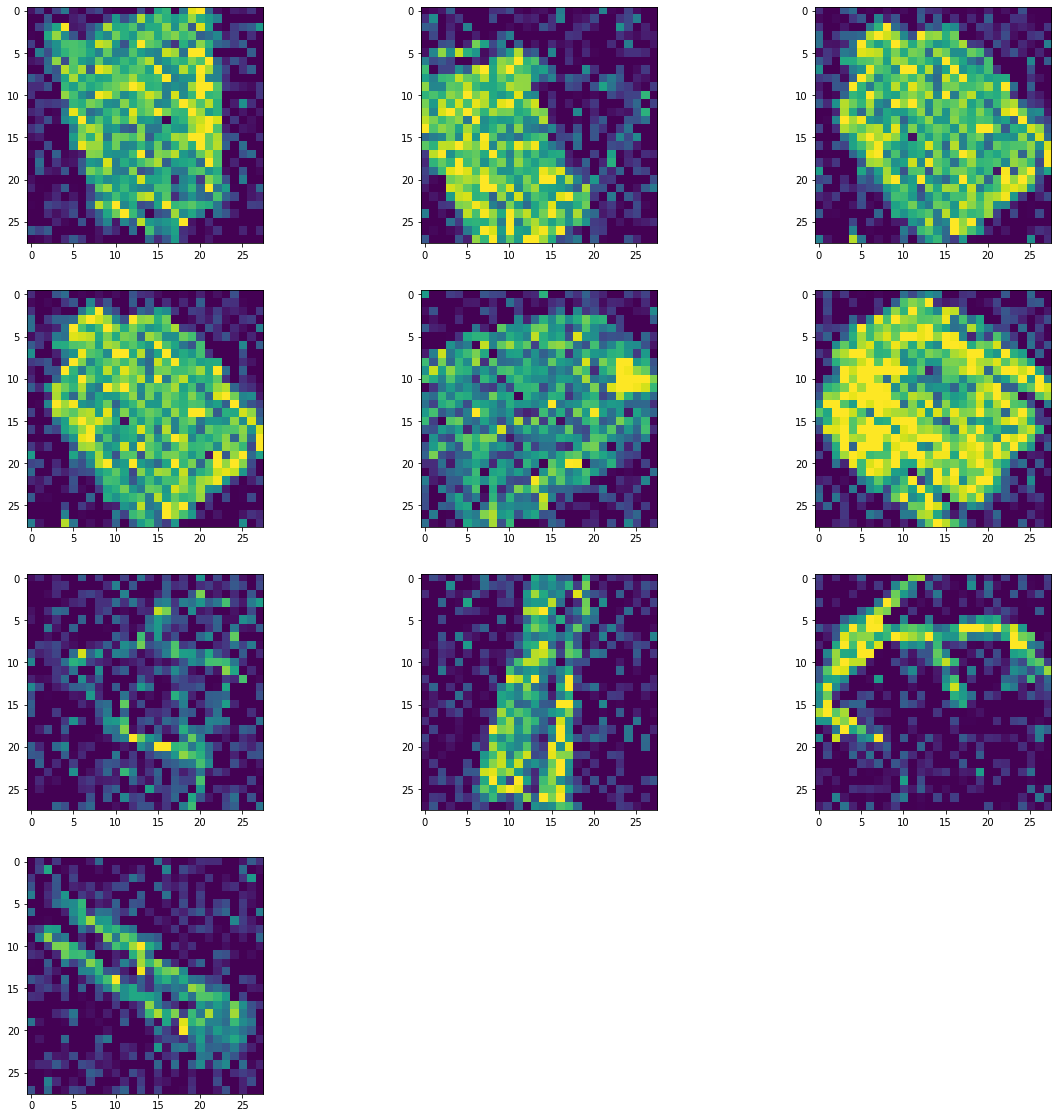

In [7]:


randImages_pos_reshaped = np.array(randImages_pos).reshape(10,28,28)
plt.figure(figsize=(20, 20))
columns = 3
rows = 4
for i in range(0,10) :
    plt.subplot(rows,columns,i+1)
    plt.imshow(randImages_pos_reshaped[i,:])
plt.show()

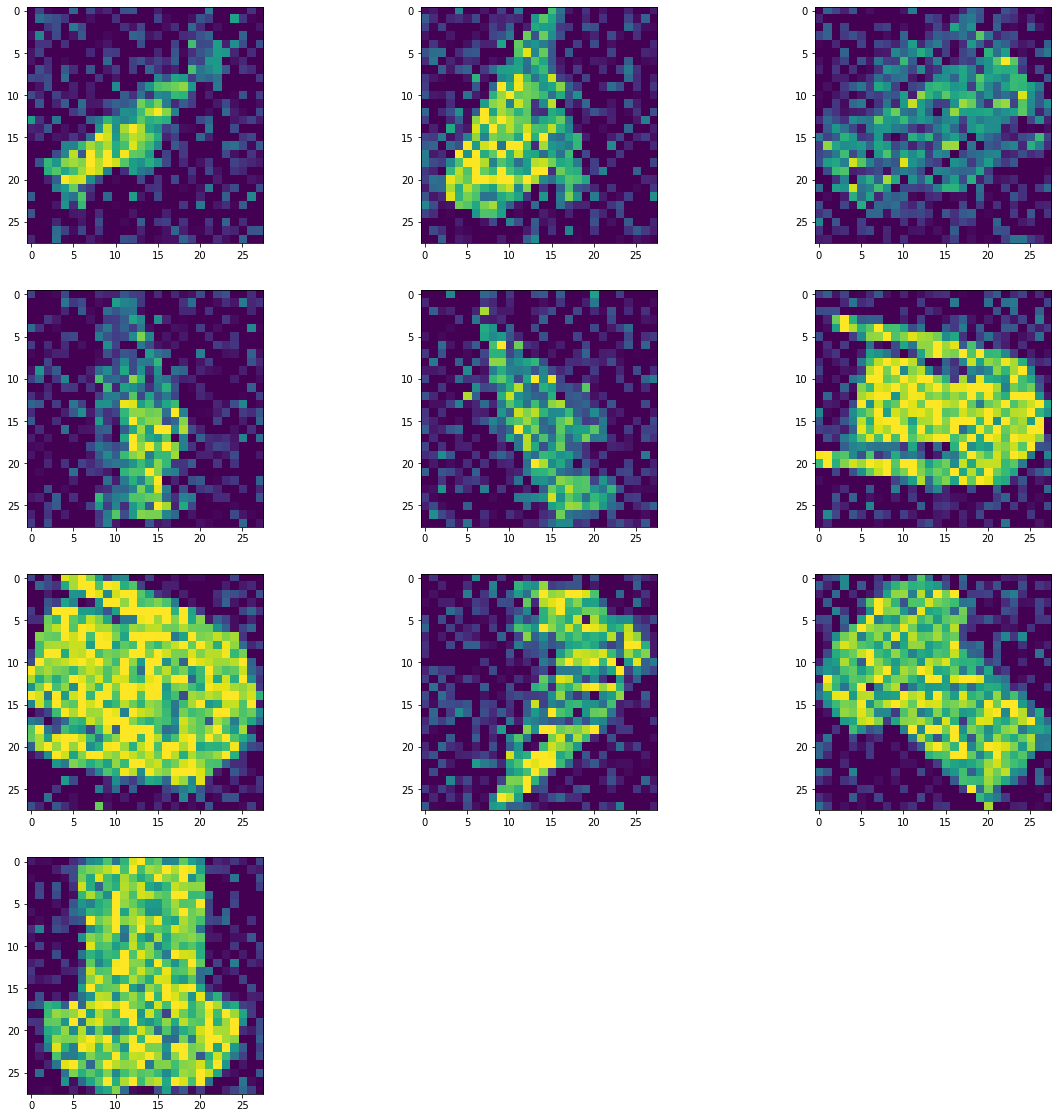

In [9]:

randImages_neg_reshaped = np.array(randImages_neg).reshape(10,28,28)
plt.figure(figsize=(20, 20))
columns = 3
rows = 4
for i in range(0,10) :
    plt.subplot(rows,columns,i+1)
    plt.imshow(randImages_neg_reshaped[i,:])
plt.show()

The number of positive examples : 2118
Number of negative examples : 882

### Performance metrics to be used

Since the class label is imbalanced, the accuracy should not be used as a performance metric since a simple classification of all examples into the majotiy class could lead to a high accuracy.

The data is imbalanced with an almost 70 - 30 split to positive examples.  

Since ROC curves will be the same no matter what the baseline probability is and the PR curves are most suited for classification problems that require more importance to be given to the minprity class, the Area Under the PR curve, in my opinion can be used as the metric to evaluate the performance of a classifier on this data.

### Stratified K Fold

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
import statistics
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

Stratified K Fold Function <br>
This function takes in the X and Y for training with an additonal parameter n_neighbors for the KNN classifier. It creates an instance of the KNN classifier with the passed in n_neighbours, fits the training data into it and performs 5 fold cross validation on the fit classifier and reports the accuracy, ROC AUC and PR AUC means and SDs over all the 5 folds.

In [11]:
def perform_stratKFold(Xtrain,Ytrain,n_neighbors=1):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    fold_accuracies = []
    roc_aucs = []
    pr_aucs = []
    fold_num = 1
    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    # Fit the classifier to the data
    knn.fit(Xtrain,Ytrain)
    for train_index, test_index in skf.split(Xtrain, Ytrain):
        x_train_fold, x_test_fold = Xtrain[train_index], Xtrain[test_index]
        y_train_fold, y_test_fold = Ytrain[train_index], Ytrain[test_index]
        knn.fit(x_train_fold, y_train_fold)
        y_pred = knn.predict_proba(x_test_fold)
        auc_score = roc_auc_score(y_test_fold,y_pred[:,1])
        print('ROC AUC for fold %d : %.3f' % (fold_num,auc_score))
        roc_aucs.append(auc_score)
        precision, recall, _ = (precision_recall_curve(y_test_fold,y_pred[:,1]))
        pr_auc = auc(recall,precision)
        print('PR AUC for fold %d : %.3f' % (fold_num,pr_auc))
        pr_aucs.append(pr_auc)
        accuracy = knn.score(x_test_fold, y_test_fold)
        print('Accuracy for fold %d : %.3f' % (fold_num,accuracy))
        fold_accuracies.append(accuracy)
        fold_num += 1
    
    print("Means and Standard deviations of the evaluation metrics over all 5 folds")
    print("---------------------Accuracy--------------------")
    print("Mean : %.3f"% statistics.mean(fold_accuracies))
    print("Standard Deviation : %.3f"% statistics.stdev(fold_accuracies))
    print("---------------------ROC AUC---------------------")
    print("Mean : %.3f"% statistics.mean(roc_aucs))
    print("Standard Deviation : %.3f"% statistics.stdev(roc_aucs))
    print("---------------------PR AUC---------------------")
    print("Mean : %.3f"% statistics.mean(pr_aucs))
    print("Standard Deviation : %.3f"% statistics.stdev(pr_aucs))

Performance metrics for all 5 folds and the mean, SD of each of them are reported in the following cell

In [12]:
perform_stratKFold(Xtrain,Ytrain)

ROC AUC for fold 1 : 0.735
PR AUC for fold 1 : 0.897
Accuracy for fold 1 : 0.752
ROC AUC for fold 2 : 0.729
PR AUC for fold 2 : 0.894
Accuracy for fold 2 : 0.747
ROC AUC for fold 3 : 0.714
PR AUC for fold 3 : 0.890
Accuracy for fold 3 : 0.748
ROC AUC for fold 4 : 0.725
PR AUC for fold 4 : 0.892
Accuracy for fold 4 : 0.742
ROC AUC for fold 5 : 0.741
PR AUC for fold 5 : 0.900
Accuracy for fold 5 : 0.772
Means and Standard deviations of the evaluation metrics over all 5 folds
---------------------Accuracy--------------------
Mean : 0.752
Standard Deviation : 0.012
---------------------ROC AUC---------------------
Mean : 0.729
Standard Deviation : 0.010
---------------------PR AUC---------------------
Mean : 0.894
Standard Deviation : 0.004


### Preprocessing

Standard Scaler

In [80]:
scaler = preprocessing.StandardScaler().fit(Xtrain)
X_scaled = scaler.transform(Xtrain)
perform_stratKFold(X_scaled,Ytrain)

ROC AUC for fold 1 : 0.742
PR AUC for fold 1 : 0.901
Accuracy for fold 1 : 0.772
ROC AUC for fold 2 : 0.702
PR AUC for fold 2 : 0.883
Accuracy for fold 2 : 0.725
ROC AUC for fold 3 : 0.698
PR AUC for fold 3 : 0.883
Accuracy for fold 3 : 0.733
ROC AUC for fold 4 : 0.737
PR AUC for fold 4 : 0.897
Accuracy for fold 4 : 0.758
ROC AUC for fold 5 : 0.731
PR AUC for fold 5 : 0.896
Accuracy for fold 5 : 0.767
Means and Standard deviations of the evaluation metrics over all 5 folds
---------------------Accuracy--------------------
Mean : 0.751
Standard Deviation : 0.021
---------------------ROC AUC---------------------
Mean : 0.722
Standard Deviation : 0.020
---------------------PR AUC---------------------
Mean : 0.892
Standard Deviation : 0.008


MinMax Scaler

In [81]:
scaler = preprocessing.MinMaxScaler().fit(Xtrain)
X_scaled = scaler.transform(Xtrain)
perform_stratKFold(X_scaled,Ytrain)

ROC AUC for fold 1 : 0.744
PR AUC for fold 1 : 0.901
Accuracy for fold 1 : 0.763
ROC AUC for fold 2 : 0.728
PR AUC for fold 2 : 0.894
Accuracy for fold 2 : 0.747
ROC AUC for fold 3 : 0.713
PR AUC for fold 3 : 0.889
Accuracy for fold 3 : 0.747
ROC AUC for fold 4 : 0.716
PR AUC for fold 4 : 0.888
Accuracy for fold 4 : 0.738
ROC AUC for fold 5 : 0.738
PR AUC for fold 5 : 0.899
Accuracy for fold 5 : 0.772
Means and Standard deviations of the evaluation metrics over all 5 folds
---------------------Accuracy--------------------
Mean : 0.753
Standard Deviation : 0.014
---------------------ROC AUC---------------------
Mean : 0.728
Standard Deviation : 0.014
---------------------PR AUC---------------------
Mean : 0.894
Standard Deviation : 0.006


Normalization

In [82]:
X_scaled = preprocessing.normalize(Xtrain, norm='l1')
perform_stratKFold(X_scaled,Ytrain)

ROC AUC for fold 1 : 0.698
PR AUC for fold 1 : 0.886
Accuracy for fold 1 : 0.753
ROC AUC for fold 2 : 0.673
PR AUC for fold 2 : 0.880
Accuracy for fold 2 : 0.752
ROC AUC for fold 3 : 0.677
PR AUC for fold 3 : 0.880
Accuracy for fold 3 : 0.743
ROC AUC for fold 4 : 0.701
PR AUC for fold 4 : 0.888
Accuracy for fold 4 : 0.763
ROC AUC for fold 5 : 0.680
PR AUC for fold 5 : 0.878
Accuracy for fold 5 : 0.738
Means and Standard deviations of the evaluation metrics over all 5 folds
---------------------Accuracy--------------------
Mean : 0.750
Standard Deviation : 0.010
---------------------ROC AUC---------------------
Mean : 0.686
Standard Deviation : 0.013
---------------------PR AUC---------------------
Mean : 0.882
Standard Deviation : 0.004


Binarizer

In [83]:
binarizer = preprocessing.Binarizer().fit(Xtrain)
X_scaled = binarizer.transform(Xtrain)
perform_stratKFold(X_scaled,Ytrain)

ROC AUC for fold 1 : 0.556
PR AUC for fold 1 : 0.826
Accuracy for fold 1 : 0.612
ROC AUC for fold 2 : 0.501
PR AUC for fold 2 : 0.811
Accuracy for fold 2 : 0.588
ROC AUC for fold 3 : 0.526
PR AUC for fold 3 : 0.812
Accuracy for fold 3 : 0.583
ROC AUC for fold 4 : 0.520
PR AUC for fold 4 : 0.816
Accuracy for fold 4 : 0.598
ROC AUC for fold 5 : 0.537
PR AUC for fold 5 : 0.821
Accuracy for fold 5 : 0.608
Means and Standard deviations of the evaluation metrics over all 5 folds
---------------------Accuracy--------------------
Mean : 0.598
Standard Deviation : 0.012
---------------------ROC AUC---------------------
Mean : 0.528
Standard Deviation : 0.020
---------------------PR AUC---------------------
Mean : 0.817
Standard Deviation : 0.006


Finding Optimum k value using GridSearchCV

In [52]:
grid_params = {
    'n_neighbors' : [3,5,7,9,11,13,15,17,19,21,23,25,27,29],
    'weights' : ['uniform','distance'],
    'metric' : ['euclidean','manhattan']
}

gs = GridSearchCV(KNeighborsClassifier(),
                 grid_params,
                 verbose = 1,
                 cv = 5,
                 n_jobs = -1)

X_scaled = preprocessing.normalize(Xtrain)
results = gs.fit(X_scaled,Ytrain)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


In [53]:
print(results.best_score_)
print(results.best_params_)

0.78
{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [54]:
perform_stratKFold(Xtrain,Ytrain,9)

ROC AUC for fold 1 : 0.779
PR AUC for fold 1 : 0.895
Accuracy for fold 1 : 0.767
ROC AUC for fold 2 : 0.777
PR AUC for fold 2 : 0.901
Accuracy for fold 2 : 0.737
ROC AUC for fold 3 : 0.781
PR AUC for fold 3 : 0.891
Accuracy for fold 3 : 0.750
ROC AUC for fold 4 : 0.762
PR AUC for fold 4 : 0.874
Accuracy for fold 4 : 0.758
ROC AUC for fold 5 : 0.789
PR AUC for fold 5 : 0.901
Accuracy for fold 5 : 0.748
Means and Standard deviations of the evaluation metrics over all 5 folds
---------------------Accuracy--------------------
Mean : 0.752
Standard Deviation : 0.011
---------------------ROC AUC---------------------
Mean : 0.778
Standard Deviation : 0.010
---------------------PR AUC---------------------
Mean : 0.892
Standard Deviation : 0.011


Using 5 fold cross validation and GridSearchCV to tune the hyperparameters of the classifier, the best value for number of neighbours was foudn out to be 9 with a PR AUC of 0.892

### Classification

In [55]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC, SVC

Perceptron

In [87]:
## HyperParameter Tuning for Perceptron model

grid_params = {
    'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
	'penalty': ['l2','l1','elasticnet',None]
}

gs = GridSearchCV(Perceptron(),
                 grid_params,
                 verbose = 1,
                 cv = 5,
                 scoring = 'average_precision',
                 n_jobs = -1)

X_scaled = preprocessing.normalize(Xtrain)
results = gs.fit(X_scaled,Ytrain)

print(results.best_params_)
print(results.best_score_)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'alpha': 0.0003, 'penalty': 'l1'}
0.7802438235237545


In [88]:
model = Perceptron()
perceptron_model = Perceptron(alpha=0.003,penalty='l1')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state= 1)
accuracy_scores = cross_val_score(perceptron_model, Xtrain, Ytrain, scoring='accuracy', cv=cv, n_jobs=-1)
roc_auc_scores = cross_val_score(perceptron_model, Xtrain, Ytrain, scoring='roc_auc', cv=cv, n_jobs=-1)
pr_auc_scores = cross_val_score(perceptron_model, Xtrain, Ytrain, scoring='average_precision', cv=cv, n_jobs=-1)

In [89]:
print('Accuracy: %.3f (%.3f)' % (statistics.mean(accuracy_scores), statistics.stdev(accuracy_scores)))
print('ROC AUC: %.3f (%.3f)' % (statistics.mean(roc_auc_scores), statistics.stdev(roc_auc_scores)))
print('PR AUC: %.3f (%.3f)' % (statistics.mean(pr_auc_scores), statistics.stdev(pr_auc_scores)))

Accuracy: 0.636 (0.064)
ROC AUC: 0.569 (0.028)
PR AUC: 0.759 (0.018)


Naive Bayes

In [90]:
grid_params = {
    'var_smoothing': [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,1,3,5,15,25,40,60,75,80],
}

gs = GridSearchCV(GaussianNB(),
                 grid_params,
                 verbose = 1,
                 scoring='average_precision',
                 cv = 5,
                 n_jobs = -1)

scaler = preprocessing.StandardScaler().fit(Xtrain)
X_scaled = scaler.transform(Xtrain)
results = gs.fit(X_scaled,Ytrain)

print(results.best_params_)
print(results.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'var_smoothing': 0.1}
0.7668491902619932


In [91]:

nb_model = GaussianNB(var_smoothing=0.1)
accuracy_scores_NB = cross_val_score(nb_model, X_scaled, Ytrain, scoring='accuracy', cv=cv, n_jobs=-1)
roc_auc_scores_NB = cross_val_score(nb_model, X_scaled, Ytrain, scoring='roc_auc', cv=cv, n_jobs=-1)
pr_auc_scores_NB = cross_val_score(nb_model, X_scaled, Ytrain, scoring='average_precision', cv=cv, n_jobs=-1)

In [92]:
print('Accuracy: %.3f (%.3f)' % (statistics.mean(accuracy_scores_NB), statistics.stdev(accuracy_scores_NB)))
print('ROC AUC: %.3f (%.3f)' % (statistics.mean(roc_auc_scores_NB), statistics.stdev(roc_auc_scores_NB)))
print('PR AUC: %.3f (%.3f)' % (statistics.mean(pr_auc_scores_NB), statistics.stdev(pr_auc_scores_NB)))

Accuracy: 0.535 (0.007)
ROC AUC: 0.574 (0.012)
PR AUC: 0.774 (0.013)


Logistic Regression

In [93]:
grid_params = dict()
grid_params['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
grid_params['C'] = [1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

gs = GridSearchCV(LogisticRegression(),
                 grid_params,
                 verbose = 1,
                 cv = 5,
                 scoring='average_precision',
                 n_jobs = -1)

scaler = preprocessing.StandardScaler().fit(Xtrain)
X_scaled = scaler.transform(Xtrain)
results = gs.fit(X_scaled,Ytrain)

print(results.best_params_)
print(results.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/rahulmenon/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'C': 0.001, 'penalty': 'l2'}
0.767898535467731


/Users/rahulmenon/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.74330317        nan 0.73640677        nan 0.74330317        nan
 0.74401423        nan 0.74330317        nan 0.76343262        nan
 0.74330317        nan 0.76789854        nan 0.74330317        nan
 0.756057          nan 0.74330317        nan 0.74652574        nan]
  warnings.warn(


In [94]:
lr_model = LogisticRegression( C = 0.001, penalty = 'l2')
accuracy_scores_lr = cross_val_score(lr_model, Xtrain, Ytrain, scoring='accuracy', cv=cv, n_jobs=-1)
roc_auc_scores_lr = cross_val_score(lr_model, Xtrain, Ytrain, scoring='roc_auc', cv=cv, n_jobs=-1)
pr_auc_scores_lr = cross_val_score(lr_model, Xtrain, Ytrain, scoring='average_precision', cv=cv, n_jobs=-1)

In [95]:
print('Accuracy: %.3f (%.3f)' % (statistics.mean(accuracy_scores_lr), statistics.stdev(accuracy_scores_lr)))
print('ROC AUC: %.3f (%.3f)' % (statistics.mean(roc_auc_scores_lr), statistics.stdev(roc_auc_scores_lr)))
print('PR AUC: %.3f (%.3f)' % (statistics.mean(pr_auc_scores_lr), statistics.stdev(pr_auc_scores_lr)))

Accuracy: 0.614 (0.016)
ROC AUC: 0.554 (0.033)
PR AUC: 0.748 (0.027)


Linear SVM

In [100]:
grid_params = dict()
grid_params['tol'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
grid_params['C'] = [0.1, 1, 10, 100, 1000]

gs = GridSearchCV(LinearSVC(),
                 grid_params,
                 verbose = 1,
                 cv = 5,
                 scoring='average_precision',
                 n_jobs = -1)

scaler = preprocessing.StandardScaler().fit(Xtrain)
X_scaled = scaler.transform(Xtrain)
results = gs.fit(X_scaled,Ytrain)

print("Best params for standard scaled data :")
print(results.best_params_)
print(results.best_score_)

scaler = preprocessing.MinMaxScaler().fit(Xtrain)
X_scaled = scaler.transform(Xtrain)
results = gs.fit(X_scaled,Ytrain)

print("Best params for MinMax scaled data :")
print(results.best_params_)
print(results.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/rahulmenon/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Best params for standard scaled data :
{'C': 1, 'tol': 0.001}
0.7435093893304
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params for MinMax scaled data :
{'C': 0.1, 'tol': 0.1}
0.746565586978129


In [105]:
lsvm_model = LinearSVC( C = 1, tol = 0.001)
scaler = preprocessing.MinMaxScaler().fit(Xtrain)
X_scaled = scaler.transform(Xtrain)
accuracy_scores_lsvm = cross_val_score(lsvm_model, X_scaled, Ytrain, scoring='accuracy', cv=cv, n_jobs=-1)
roc_auc_scores_lsvm = cross_val_score(lsvm_model, X_scaled, Ytrain, scoring='roc_auc', cv=cv, n_jobs=-1)
pr_auc_scores_lsvm = cross_val_score(lsvm_model, X_scaled, Ytrain, scoring='average_precision', cv=cv, n_jobs=-1)

In [106]:
print('Accuracy: %.3f (%.3f)' % (statistics.mean(accuracy_scores_lsvm), statistics.stdev(accuracy_scores_lsvm)))
print('ROC AUC: %.3f (%.3f)' % (statistics.mean(roc_auc_scores_lsvm), statistics.stdev(roc_auc_scores_lsvm)))
print('PR AUC: %.3f (%.3f)' % (statistics.mean(pr_auc_scores_lsvm), statistics.stdev(pr_auc_scores_lsvm)))

Accuracy: 0.621 (0.020)
ROC AUC: 0.554 (0.035)
PR AUC: 0.749 (0.027)


Kernalized SVM

In [172]:
grid_params = dict()
grid_params['degree'] = range(1,4)
grid_params['C'] = range(1,4)
grid_params['kernel'] = ['poly']

gs = GridSearchCV(SVC(cache_size=800),
                 grid_params,
                 verbose = 1,
                 cv = 5,
                 scoring='average_precision',
                 n_jobs = -1)

scaler = preprocessing.StandardScaler().fit(Xtrain)
X_scaled = scaler.transform(Xtrain)
results = gs.fit(X_scaled,Ytrain)

print(results.best_params_)
print(results.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'C': 3, 'degree': 3, 'kernel': 'poly'}
0.8873619629284353


In [173]:
svm_model = SVC( C = 3, degree = 3, kernel='poly',cache_size=800)
accuracy_scores_svm = cross_val_score(svm_model, X_scaled, Ytrain, scoring='accuracy', cv=cv, n_jobs=-1)
roc_auc_scores_svm = cross_val_score(svm_model, X_scaled, Ytrain, scoring='roc_auc', cv=cv, n_jobs=-1)
pr_auc_scores_svm = cross_val_score(svm_model, X_scaled, Ytrain, scoring='average_precision', cv=cv, n_jobs=-1)

In [174]:
print('Accuracy: %.3f (%.3f)' % (statistics.mean(accuracy_scores_svm), statistics.stdev(accuracy_scores_svm)))
print('ROC AUC: %.3f (%.3f)' % (statistics.mean(roc_auc_scores_svm), statistics.stdev(roc_auc_scores_svm)))
print('PR AUC: %.3f (%.3f)' % (statistics.mean(pr_auc_scores_svm), statistics.stdev(pr_auc_scores_svm)))

Accuracy: 0.772 (0.012)
ROC AUC: 0.794 (0.018)
PR AUC: 0.892 (0.019)


### PCA Dimensionality Reduction

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [115]:
pca = PCA(n_components=2)

In [186]:
scaler = preprocessing.MinMaxScaler().fit(Xtrain)
X_scaled = scaler.transform(Xtrain)
print(X_scaled.shape)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print(X_pca.shape)
print(X_pca)

(3000, 784)
(3000, 529)
[[-4.16380365 -1.03237615 -1.11008536 ...  0.01351358  0.11261902
  -0.10395251]
 [ 5.12998396 -2.37312426  0.99956455 ...  0.19332361 -0.19136731
  -0.13175642]
 [ 0.36306269  5.51662208 -0.45475002 ... -0.20030491  0.11135081
  -0.07241679]
 ...
 [-2.51459423  3.02449939  2.48547784 ... -0.24979581  0.04647083
  -0.16230411]
 [-2.79742319  2.23040438  0.91739285 ... -0.14427049  0.21777219
  -0.02463335]
 [-5.54760048 -0.2295773  -1.3571671  ... -0.19775145  0.06852054
  -0.22571495]]


Text(0, 0.5, 'PC2')

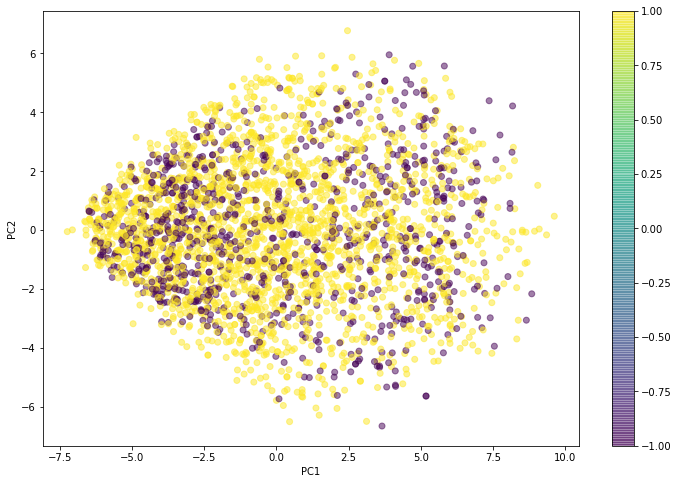

In [187]:
plt.figure(figsize=(12,8))
plt.scatter(X_pca[:,0],X_pca[:,1],c=Ytrain,alpha=0.5)
plt.colorbar()
plt.xlabel("PC1")
plt.ylabel("PC2")

The scatter plot shows the values along the 2 principal components. For PC1, which is zero centric, we can see that most of the values are concentrated in the low variance region ( to the left of the modpoint on the X Axis). In case of PC2, the values seem to be evenly spread around the center indicating a uniform distribution of values with low and high variances

Finding number of components that describe 95% of the data

Number of components explaining 95% variance is : 512
(3000, 512)
512


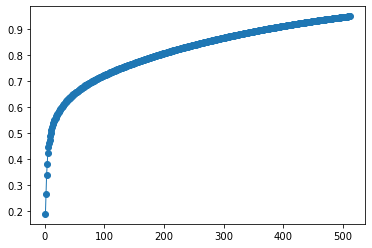

In [188]:
pca_95 = PCA(n_components=0.95)
pca_95.fit(X_scaled)
X_pca95 = pca_95.transform(X_scaled)
print("Number of components explaining 95% variance is : " + str(X_pca95.shape[1]))
principlal_components = np.arange(len(pca_95.explained_variance_ratio_))
explained_variance = np.cumsum(pca_95.explained_variance_ratio_)
plt.plot(principlal_components+1,explained_variance, marker='o', linestyle='-', linewidth=1)
print(pca_95.transform(X_scaled).shape)
print(len(principlal_components))


Since the number of columns of the reduced data with n_components = 0.95 is 529, there are 529 components that describe 95% of the variance in the data

Kernalised SVM for data reduced to 2 dimensions using PCA

In [189]:
grid_params = dict()
grid_params['degree'] = range(1,4)
grid_params['C'] = range(1,4)
grid_params['kernel'] = ['poly']

gs = GridSearchCV(SVC(cache_size=800),
                 grid_params,
                 verbose = 1,
                 cv = 5,
                 scoring='average_precision',
                 n_jobs = -1)


results = gs.fit(X_pca95,Ytrain)

print(results.best_params_)
print(results.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'C': 3, 'degree': 3, 'kernel': 'poly'}
0.8845886045773146


In [190]:
svm_model_pca = SVC( C = 3, degree = 3, kernel='poly')
accuracy_scores_svm_pca = cross_val_score(svm_model_pca, X_pca95, Ytrain, scoring='accuracy', cv=cv, n_jobs=-1)
roc_auc_scores_svm_pca = cross_val_score(svm_model_pca, X_pca95, Ytrain, scoring='roc_auc', cv=cv, n_jobs=-1)
pr_auc_scores_svm_pca = cross_val_score(svm_model_pca, X_pca95, Ytrain, scoring='average_precision', cv=cv, n_jobs=-1)

In [191]:
print('Accuracy: %.3f (%.3f)' % (statistics.mean(accuracy_scores_svm_pca), statistics.stdev(accuracy_scores_svm_pca)))
print('ROC AUC: %.3f (%.3f)' % (statistics.mean(roc_auc_scores_svm_pca), statistics.stdev(roc_auc_scores_svm_pca)))
print('PR AUC: %.3f (%.3f)' % (statistics.mean(pr_auc_scores_svm_pca), statistics.stdev(pr_auc_scores_svm_pca)))

Accuracy: 0.775 (0.009)
ROC AUC: 0.798 (0.024)
PR AUC: 0.892 (0.023)


### Selecting the best model and creating a pipeline

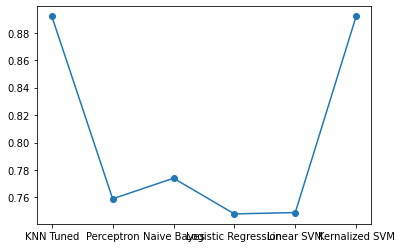

In [194]:
x = ['KNN Tuned', 'Perceptron', 'Naive Bayes', 'Logistic Regression','Linear SVM', 'Kernalized SVM']
y = [0.892,0.759,0.774,0.748,0.749,0.892]

plt.plot(x,y,marker='o')

The Kernalized SVM with the tuned hyperparameters along with the KNN is giving the highest average PR AUC. The pipeline will be created using Kernalized SVM

In [193]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Xtrain = np.loadtxt('Xtrain.csv')
Ytrain = np.loadtxt('Ytrain.csv')
Xtest = np.loadtxt('Xtest.csv')


pipeline = Pipeline([
    ('scale' , MinMaxScaler()),
    ('pca' , PCA(n_components=529)),
    ('classifier' , SVC(C=3, degree=3, kernel='poly', probability=True))
])

pipeline.fit(Xtrain,Ytrain)

Y_pred = pipeline.predict_proba(Xtest)


np.savetxt('modelPredictions.csv',Y_pred[:,1],fmt="%.3f")